# Feature Selection

The goal of this notebook is to perform the feature selection. There are two methods that will be used to perform the feature selection:
1. Random forest - The features will be ranked based on the importance score provided by the random forest classifier and the top $n$ features will be selected
2. Brute force - Train the ML models by using different number of features. The accuracy of each model with respect to the number of features will be recorded to select the most concise feature set.

In [1]:
# import all necessary packages

# basic packages for data processing
import os       # to create directories and remove files
import pandas as pd
import numpy as np 
import random # import random package to specify the random seed

# modules for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# modules to interpret the training result
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

# silent the warning from the sklearn library
import warnings
warnings.filterwarnings('ignore')

# set the random seed to ensure the result is reproducible
random.seed(10)
np.random.seed(10)

Load the dataset

As the dataset is quite large, only 10% of the dataset will be used for feature selection

In [2]:
# read the dataset from files
ids2017 = pd.read_csv('Dataset/dataset_cleaned/CIC-IDS2017.csv')
ids2017 = ids2017.sample(frac=0.1).reset_index(drop=True)
ids2017.shape

(64976, 78)

## Step 2. Random forest feature selection

In this step, the features will be selected using the random forest algorithm. First, a random forest will be trained. After that, the features will be ranked according to the importance score provided by the random forest and the top $n$ features will be selected.In this step, the features will be selected using the random forest algorithm. First, a random forest will be trained. After that, the features will be ranked according to the importance score provided by the random forest and the top $n$ features will be selected.

In [3]:
ids2017_X = ids2017.drop('Label', axis=1).copy()
ids2017_y = ids2017['Label'].copy()

In [4]:
X_columns = ids2017_X.columns
ids2017_X = StandardScaler().fit_transform(ids2017_X)

In [5]:
%%time
rfc = RandomForestClassifier()

# fit random forest classifier on the training set
rfc.fit(ids2017_X, ids2017_y)

Wall time: 9.64 s


RandomForestClassifier()

Top 20 features: 
                             importance
feature                                
Bwd Packet Length Std             0.075
Average Packet Size               0.067
Max Packet Length                 0.047
Packet Length Variance            0.044
Packet Length Std                 0.043
Avg Bwd Segment Size              0.038
Packet Length Mean                0.037
Destination Port                  0.037
Init_Win_bytes_forward            0.031
Fwd Packet Length Mean            0.029
Init_Win_bytes_backward           0.029
Subflow Bwd Bytes                 0.028
Bwd Packet Length Max             0.028
Total Length of Bwd Packets       0.027
Bwd Packet Length Mean            0.026
Fwd Packet Length Max             0.026
Bwd Packet Length Min             0.025
Subflow Fwd Bytes                 0.024
Avg Fwd Segment Size              0.020
Fwd Header Length                 0.018


<AxesSubplot:xlabel='feature'>

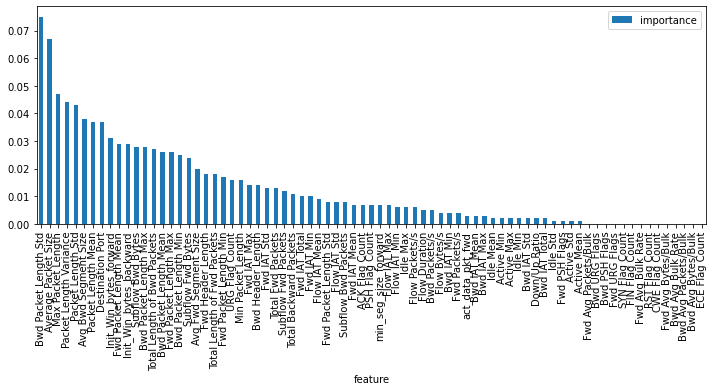

In [6]:
# extract the importance score from the random forest classifier
score = np.round(rfc.feature_importances_, 3)
importance = pd.DataFrame({'feature': X_columns, 
                            'importance': score})
importance = importance.sort_values('importance', ascending=False).set_index('feature')

print(f"Top 20 features: \n{importance[:20]}")

plt.rcParams['figure.figsize'] = (12, 4)
importance.plot.bar()

### Save the features

In [7]:
def save_feature(features: pd.Series, dataset_name: str, algorithm: str, tag: str = ""):
    
    feature_count = features.shape[0]

    if not(tag == ""):
        tag = "_" + tag
    
    directory = 'Dataset/features_selected'
    file_name = f"{dataset_name}_{algorithm}_{feature_count}{tag}"
    
    # create directory to save the file
    os.makedirs(directory, exist_ok=True)
    
    features.to_csv(f"{directory}/{file_name}.csv", index=False, columns=None)

    print(f"The features have been saved in {directory}/{file_name}.csv")

In [8]:
features = pd.Series(importance.index[:20], dtype='str')
save_feature(features=features, 
            dataset_name='CIC-IDS2017', 
            algorithm='RandomForestClassifier')

The features have been saved in Dataset/features_selected/CIC-IDS2017_RandomForestClassifier_20.csv


## Step 3. Brute force

After selecting the features using random forest, the number of features will be further reduced using brute force. The method is quite simple, the ML models will be trained using different number of features. The feature set that can gives comparable accuracy with the least number of features will be the final feature set. 

 Started from the $1^{st}$ ranked feature, features will be added until all $n$ features are used. As the LUFlow dataset only contain a few number of features, the $n$ is equal to the total number of features.## Step 3. Brute force

After selecting the features using random forest, the number of features will be further reduced using brute force. The method is quite simple, the ML models will be trained using different number of features. The feature set that can gives comparable accuracy with the least number of features will be the final feature set. 

 Started from the $1^{st}$ ranked feature, features will be added until all $n$ features are used. For the CIC-IDS2017 dataset, the $n$ is equals to $20$.

In [9]:
columns = features.tolist() +  ['Label']

ids2017 = ids2017[columns]
ids2017.shape

(64976, 21)

In [10]:
ids2017_X = ids2017.drop('Label', axis=1).copy()
ids2017_y = ids2017['Label'].copy()

ids2017_train_X, ids2017_test_X, ids2017_train_y, ids2017_test_y = train_test_split(ids2017_X, ids2017_y, test_size=0.3)

In [11]:
# define ML models without optimized hyperparameter
models = {
    'Decision Tree': tree.DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_jobs=-1),
    'Support Vector Machine': SVC(),
    'Naive Bayes': GaussianNB(),
    'Artificial Neural Network': MLPClassifier(hidden_layer_sizes=(40), max_iter=500),
    'Deep Neural Network': MLPClassifier(hidden_layer_sizes=(12, 12, 12), max_iter=500)
}

In [12]:
feature_set = []
scalar = StandardScaler()
scores = []

for feature in features:
    feature_set.append(feature)
    print(f"Added feature {len(feature_set)} ({feature})...")\
    
    test_X = ids2017_test_X[feature_set]
    train_X = ids2017_train_X[feature_set]

    # scale the dataset
    train_X_scaled = scalar.fit(train_X)
    train_X_scaled = scalar.transform(train_X)
    test_X_scaled = scalar.transform(test_X)

    score_temp = [len(feature_set)]

    for model in models:
        clf = models[model]
        clf.fit(train_X_scaled, ids2017_train_y)

        prediction = clf.predict(test_X_scaled)
        accuracy = metrics.accuracy_score(ids2017_test_y, prediction)

        score_temp.append(accuracy)

    scores.append(score_temp)


scores = np.array(scores)

Added feature 1 (Bwd Packet Length Std)...
Added feature 2 (Average Packet Size)...
Added feature 3 (Max Packet Length)...
Added feature 4 (Packet Length Variance)...
Added feature 5 (Packet Length Std)...
Added feature 6 (Avg Bwd Segment Size)...
Added feature 7 (Packet Length Mean)...
Added feature 8 (Destination Port)...
Added feature 9 (Init_Win_bytes_forward)...
Added feature 10 (Fwd Packet Length Mean)...
Added feature 11 (Init_Win_bytes_backward)...
Added feature 12 (Subflow Bwd Bytes)...
Added feature 13 (Bwd Packet Length Max)...
Added feature 14 (Total Length of Bwd Packets)...
Added feature 15 (Bwd Packet Length Mean)...
Added feature 16 (Fwd Packet Length Max)...
Added feature 17 (Bwd Packet Length Min)...
Added feature 18 (Subflow Fwd Bytes)...
Added feature 19 (Avg Fwd Segment Size)...
Added feature 20 (Fwd Header Length)...


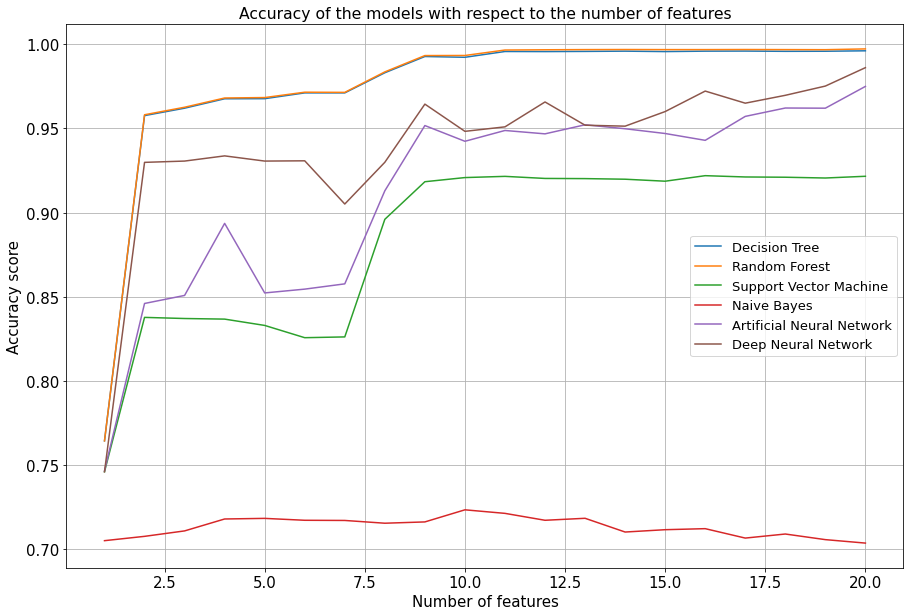

In [15]:
plt.figure(figsize=(15, 10))
for index, model in enumerate(models):
    plt.plot(scores.T[0], scores.T[index + 1], label=model)

plt.rcParams.update({'font.size': 13})
plt.title('Accuracy of the models with respect to the number of features')
plt.xlabel('Number of features')
plt.ylabel('Accuracy score')
plt.legend()
plt.grid()
plt.show()